# SciPy 2016 Scikit-learn Tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Automatic Feature Selection
Often we collected many features that might be related to a supervised prediction task, but we don't know which of them are actually predictive. To improve interpretability, and sometimes also generalization performance, we can use automatic feature selection to select a subset of the original features. There are several types of feature selection methods available, which we'll explain in order of increasing complexity.

For a given supervised model, the best feature selection strategy would be to try out each possible subset of the features, and evaluate generalization performance using this subset. However, there are exponentially many subsets of features, so this exhaustive search is generally infeasible. The strategies discussed below can be thought of as proxies for this infeasible computation.

### Univariate statistics
The simplest method to select features is using univariate statistics, that is by looking at each feature individually and running a statistical test to see whether it is related to the target. This kind of test is also known as analysis of variance (ANOVA).

We create a synthetic dataset that consists of the breast cancer data with an additional 50 completely random features.

In [2]:
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target,
                                                    random_state=0, test_size=.5)

We have to define a threshold on the p-value of the statistical test to decide how many features to keep. There are several strategies implemented in scikit-learn, a straight-forward one being ``SelectPercentile``, which selects a percentile of the original features (we select 50% below):

In [3]:
from sklearn.feature_selection import SelectPercentile

# use f_classif (the default) and SelectPercentile to select 50% of features:
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set:
X_train_selected = select.transform(X_train)

print(X_train.shape)
print(X_train_selected.shape)

(284, 80)
(284, 40)


We can also use the test statistic directly to see how relevant each feature is. As the breast cancer dataset is a classification task, we use f_classif, the F-test for classification. Below we plot the p-values associated with each of the 80 features (30 original features + 50 noise features). Low p-values indicate informative features.

In [4]:
from sklearn.feature_selection import f_classif, f_regression, chi2

In [5]:
F, p = f_classif(X_train, y_train)

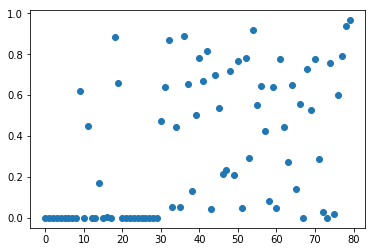

In [6]:
plt.figure()
plt.plot(p, 'o')

Clearly most of the first 30 features have very small p-values.

Going back to the SelectPercentile transformer, we can obtain the features that are selected using the ``get_support`` method:

[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


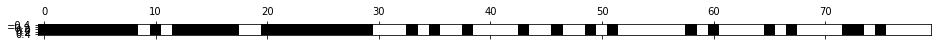

In [7]:
mask = select.get_support()
print(mask)
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

Nearly all of the original 30 features were recovered.
We can also analize the utility of the feature selection by training a supervised model on the data.
It's important to learn the feature selection only on the training set!

In [8]:
from sklearn.linear_model import LogisticRegression

# transform test data:
X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Score with all features: %f" % lr.score(X_test, y_test))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: %f" % lr.score(X_test_selected, y_test))

Score with all features: 0.929825
Score with only selected features: 0.940351


### Model-based Feature Selection
A somewhat more sophisticated method for feature selection is using a supervised machine learning model and selecting features based on how important they were deemed by the model. This requires the model to provide some way to rank the features by importance. This can be done for all tree-based models (which implement ``get_feature_importances``) and all linear models, for which the coefficients can be used to determine how much influence a feature has on the outcome.

Any of these models can be made into a transformer that does feature selection by wrapping it with the ``SelectFromModel`` class:

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold="median")

In [10]:
select.fit(X_train, y_train)
X_train_rf = select.transform(X_train)
print(X_train.shape)
print(X_train_rf.shape)

(284, 80)
(284, 40)


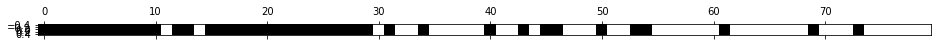

In [11]:
mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [12]:
X_test_rf = select.transform(X_test)
LogisticRegression().fit(X_train_rf, y_train).score(X_test_rf, y_test)

0.9508771929824561

This method builds a single model (in this case a random forest) and uses the feature importances from this model.
We can do a somewhat more elaborate search by training multiple models on subsets of the data. One particular strategy is recursive feature elimination:

### Recursive Feature Elimination
Recursive feature elimination builds a model on the full set of features, and similar to the method above selects a subset of features that are deemed most important by the model. However, usually only a single feature is dropped from the dataset, and a new model is built with the remaining features. The process of dropping features and model building is repeated until there are only a pre-specified number of features left:

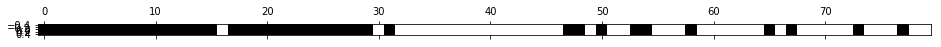

In [13]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=40)

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [14]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)

0.9508771929824561

In [15]:
select.score(X_test, y_test)

0.9508771929824561

# Exercise

Create the "XOR" dataset which is created like this:

In [16]:
import numpy as np

rng = np.random.RandomState(1)

# Generate 400 random integers in the range [0, 1]
X = rng.randint(0, 2, (200, 2))
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

Add random features to it and compare how univariate selection compares to model based selection using a Random Forest in recovering the original features.

In [18]:
# %load solutions/20_univariate_vs_mb_selection.py
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rng = np.random.RandomState(1)
X = rng.randint(0, 2, (200, 20))
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

fs_univariate = SelectKBest(k=10)
fs_modelbased = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='median')

fs_univariate.fit(X, y)
print('Features selected by univariate selection:')
print(fs_univariate.get_support())
print('')

fs_modelbased.fit(X, y)
print('Features selected by model-based selection:')
print(fs_modelbased.get_support())


Features selected by univariate selection:
[False False False  True  True False  True  True False False False  True
 False  True False  True  True False  True  True]

Features selected by model-based selection:
[ True  True False  True  True False  True  True False False  True False
 False False False  True  True False False  True]
